In [64]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import plotly.express as px


In [2]:
#Import the data and clean the DF
df = pd.read_csv("data/aggregated_DB.csv", low_memory=False)
df = df.drop_duplicates(subset='tweet', keep="first")

df_add = pd.read_csv("data/stored_vars_hr_update_2018.csv",lineterminator='\n')
df = df.append(df_add)
df_add = pd.read_csv("data/stored_vars_hr_update_2017.csv",lineterminator='\n')
df = df.append(df_add)
df_add = pd.read_csv("data/stored_vars_hr_update_2016.csv",lineterminator='\n')
df = df.append(df_add)
df.to_csv("data/aggregated_DB_2023.csv")


#Clean the dataframe, assume perfectly repeated tweets are likely noise 
df = df.drop_duplicates(subset='tweet', keep="first")
df = df[['date', 'tweet']]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
print(df.shape)

/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_50454/73806642.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_add)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_50454/73806642.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_add)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_50454/73806642.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_add)


(2393262, 2)


In [3]:
#___________________________settings for estimation ____________________
#Threshold for sentiment classification => range: (1,0)
#Purpose: option discrete assigns aa value of one when the absolute value of sentiment is above a certain threshold
#This introduces convexity in the classification and it makes the signal a bit easier to interpet 
continuous_or_discrete = "disc"
threshold = 0.3
#Use Naive Bayes to trim irrelevant tweets 
bayes = 0 #this option is a work in progress, 1 = YES, 0 = NO
#_______________________________________________________________________

#define a DF to store the last estimation parameters
settings = {'Setting':['cont_or_disc', 'threshold', 'bayes'],
              'value':[continuous_or_discrete, threshold, bayes]}

settings_df = pd.DataFrame(settings)
settings_df.to_csv(f"results/settings_{continuous_or_discrete}.csv")
print(settings_df)

        Setting value
0  cont_or_disc  disc
1     threshold   0.3
2         bayes     0


In [4]:
#Define a function to clean tweet by removing special characters and whitespace using regex
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",str(tweet)) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", str(tweet)) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet

df['tweet_clean'] = df['tweet'].apply(cleaner)
df = df.drop('tweet', axis=1)
df = df.drop_duplicates(subset='tweet_clean', keep="first")


In [5]:
#Uncomment the Following two lines if not already downloaded:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
#nltk.download('words')
sid = SentimentIntensityAnalyzer()
words = set(nltk.corpus.words.words())

#Loop over values and calculate sentiment + add to the DF
df = df.reset_index()
list1 = []
for i in df['tweet_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

df['sentiment'] = pd.Series(list1)
df.to_csv('temp/tempsave.csv')

In [6]:
df = pd.read_csv('temp/tempsave.csv')

#Import csv of keywords derived from michigan survey
df_kws = pd.read_csv("kws/kws.csv")
#Create lists of keywords and keyword categories for aggregagation
kw_list = df_kws['Indicator'].values.tolist()
category_list = df_kws['Category'].values.tolist()
category_list = [*set(category_list)]
print(f"The list of aggregate categories is: {category_list}")

#Detect which keyword was used and store in DF
#Note: this wouldn't be necessary if i had saved the keyword in the initial scraping step: a lesson learned
df['Indicator'] = np.nan
for term in kw_list:
    df['Indicator'] = np.where(df['tweet_clean'].str.contains(term, case=False) == True, term, df['Indicator'])

#Merge in df containing keyword categories
df = pd.merge(df_kws, df, on='Indicator')

#After this point you will have a DF with one row for each tweet, each row will have a sentiment score and associated tags
df = df[['date', 'sentiment', 'Indicator', 'Category']]

The list of aggregate categories is: ['personal', 'policy', 'prices', 'general']


In [7]:
#Map continuous score to discrete: Positive, neutral, negative  --> if the option is selected by the user
if continuous_or_discrete == 'disc':
    df['sentiment_score'] = pd.cut(x=df['sentiment'], 
                                   bins=[-1.1,(-1)*threshold,threshold,1.1],
                                   labels =[-1,0,1])
    #convert the sentiment category to a numerical score in the set  {-1,0,1}
    df['sentiment_score'] = pd.factorize(df['sentiment_score'])[0] - 1

else:
    df['sentiment_score'] = df['sentiment']
    
df.tail()

,date,sentiment,Indicator,Category,sentiment_score
1631751,2016-12-30 19:30:03,0.7906,Cost of living,prices,1
1631752,2016-12-30 19:26:28,0.6239,Cost of living,prices,1
1631753,2016-12-30 19:21:40,0.1531,Cost of living,prices,0
1631754,2016-12-30 19:00:49,0.4877,Cost of living,prices,1
1631755,2016-12-30 19:00:31,-0.1531,Cost of living,prices,0


In [8]:
#Use pivot to create a column for each category
aggregations = ["Category", "Indicator"]

for agg_by in aggregations:
    print(agg_by)
    df_p = df.pivot_table(index='date', columns=f"{agg_by}", values='sentiment_score', aggfunc='mean')
    df_count = df.pivot_table(index='date', columns=f"{agg_by}", values='sentiment_score', aggfunc='count')
    
    df_p.to_csv(f"results/pivot_{agg_by}.csv")
    df_count.to_csv(f"results/pivot_count_{agg_by}.csv")

#The resulting df will become wider after the pivot
#Each row will be a unique time observation, and will have an associated sentiment score + count (1)

Category
Indicator


In [12]:

#This is when the final stages of analysis begin, the data has been prepped and shaped
#It is just a matter of defining the desired aggregation 

#Choose To aggregate by Category or Indictor
agg_by = "Category"


#Will loop over both count and score to deliver daily aggregations of both
type = ["", "_count"]

for type_stat in type:

    df = pd.read_csv(f"results/pivot{type_stat}_{agg_by}.csv")
    print(f"The uncollapsed df is: {df.shape}")
    #Setting the date to datetime for aggregation purposes
    df = df.reset_index()
    df_c = df[df['date'].str.contains( "'" )==False]
    df_c['date'] = pd.to_datetime(df_c['date'], format='%Y-%m-%d %H:%M:%S')
    df_c = df_c.set_index('date')
    
    if type_stat == "_count":
        agg_count = df_c.resample('D').count()
    else:
        agg_means = df_c.resample('D').mean()
        
    print(f"The daily aggregated {type_stat} df is: {agg_means.shape}")


The uncollapsed df is: (1557110, 5)
The daily aggregated  df is: (2577, 5)
The uncollapsed df is: (1557110, 5)
The daily aggregated _count df is: (2577, 5)


In [23]:
import plotly.io as pio
pio.templates


def plot_clean(df, vars, title_in):

    fig = px.line(df, x=df.index, y=vars, title=title_in, template="simple_white",width = 700)
    fig.update_layout(
        font_family="Georgia",
        font_color="black",
    )
    fig.show()

#Plot both of the data series 
plot_clean(agg_count, ['general','prices'], 'Raw Counts 2016-2023' )
plot_clean(agg_means, ['general','prices'], 'Raw scores 2016-2023' )


In [20]:
#Data check:
# Find the missing dates by comparing the index to a range of all possible dates
all_dates = pd.date_range(agg_means.index.min(), agg_means.index.max())
missing_dates = set(all_dates) - set(agg_means.index)
print(missing_dates)

set()


In [22]:

#Collect Michigan Consumer Survey data and add onto the dataframe 
#Link to csv was found here: http://www.sca.isr.umich.edu/tables.html
collect_mich = 1

if collect_mich:
    df_mich = pd.read_csv("http://www.sca.isr.umich.edu/files/tbmics.csv")
    df_mich['date'] = pd.to_datetime(df_mich['YYYY'].astype(str) + ' ' + df_mich['Month'] + ' 28', format='%Y %B %d')
    df_mich = df_mich.set_index('date')
    df_mich.to_csv('data/mich_sent.csv')
else:
    df_mich = pd.read_csv('data/mich_sent.csv')


In [80]:
#Scale to match
#df_mich['ICS_ALL'] = 1.5*df_mich['ICS_ALL'] - 250

#Collect both the daily average score and count into one dataframe
merged_df = pd.merge(agg_count, agg_means, left_index=True, right_index=True, how='inner')
#X refers to score, y refers to count
#Create a custom score metric and take a moving average
for cat in category_list:   
    merged_df[cat +"_z"] = (merged_df[cat +"_x"]) / (merged_df[cat +"_x"].mean())
    merged_df[cat +"_score"] = merged_df[cat +"_y"]
    merged_df[cat +"_score"] = merged_df[cat +"_score"].rolling(30).mean()
    merged_df[cat +" std."] = stats.zscore(merged_df[cat +"_score"], nan_policy='omit')



#Merge the michigan sentiment with twitter sentiment
merged_plot = pd.merge(merged_df, df_mich, left_index=True, right_index=True, how='left')
#fix missing values due to michigan being monthly and sentiment being daily
merged_plot = merged_plot.interpolate()
merged_plot["Mich. Sentiment std."] = stats.zscore(merged_plot["ICS_ALL"], nan_policy='omit')

merged_plot['total'] = (merged_plot['general_score'] + merged_plot['prices_score'])
merged_plot["Twitter Sentiment std."] = stats.zscore(merged_plot["total"], nan_policy='omit')

merged_plot['general'] = (merged_plot['general_score'])*180 + 100
merged_plot = merged_plot.iloc[32: , :]


#Plot the two for comparison
#plot_clean(merged_plot, ['general_score','prices_score','ICS_ALL'], 'Rolling 30 Day avg sentiment' )
#plot_clean(merged_plot, ['total','ICS_ALL'], 'Rolling 30 Day avg sentiment')
plot_clean(merged_plot, ['Twitter Sentiment std.','Mich. Sentiment std.'], 'Rolling 30 Day avg sentiment')



In [59]:
import statsmodels.api as sm # import statsmodels 

df_reg=merged_plot.dropna(subset=['Month'])
df_reg.head()
#X = np.array(df_reg['policy_score'],df_reg['general_score'])
#Y = np.array(df_reg['ICS_ALL'])

X = df_reg[['prices_score', 'general_score']]
X = sm.add_constant(X)
y = df_reg['ICS_ALL']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ICS_ALL   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     38.36
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           2.08e-12
Time:                        14:46:15   Log-Likelihood:                -310.35
No. Observations:                  83   AIC:                             626.7
Df Residuals:                      80   BIC:                             634.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            70.6186      2.900     24.350      0.000      64.847      76.390
prices_score    162.4055     18.916      8.585      0.000     124.761     200.050
general_score   -55.8480     26.900     -2.076      0.041    -109.381      -2.314
==============================================================================
Omnibus:                        8.048   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.374
Skew:                          -0.744   Prob(JB):                       0.0152
Kurtosis:                       2.547   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
from config

ModuleNotFoundError: No module named 'config'

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('temp/tempsave.csv')
#Y - M - D


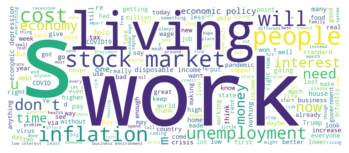

In [79]:
start_date = '2020-03-01'
end_date = '2020-04-31'
mask = (df['date'] > start_date) & (df['date'] <= end_date)
df_inspect = df.loc[mask]

text = " ".join(review for review in df_inspect.tweet_clean)

# Create and generate a word cloud image:
wordcloud = WordCloud(width = 1200, height = 500, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
df_reg.head()

,index_x,general_x,personal_x,policy_x,prices_x,index_y,general_y,personal_y,policy_y,prices_y,...,policy_score,prices_z,prices_score,general_z,general_score,Month,YYYY,ICS_ALL,total,general
date,,,,,,,,,,,,,,,,,,,,,
2016-01-28,506,299,37,27,150,12901.5,-0.140468,0.135135,0.259259,-0.006667,...,NaN,0.791509,NaN,0.894659,NaN,January,2016.0,92.0,NaN,NaN
2016-02-28,392,239,26,15,116,27294.5,-0.133543,0.230769,0.000000,0.086207,...,0.099814,0.612100,0.063166,0.715129,-0.131358,February,2016.0,91.7,72.725463,76.355501
2016-03-28,470,248,36,16,177,40291.5,-0.157258,0.138889,0.187500,0.067797,...,0.043687,0.933981,0.069716,0.742058,-0.132816,March,2016.0,91.0,73.642040,76.093122
2016-04-28,454,277,29,15,136,53816.5,-0.169675,0.172414,0.400000,0.073529,...,0.033289,0.717635,0.054914,0.828831,-0.144442,April,2016.0,89.0,68.884941,74.000488
2016-05-28,377,258,9,14,99,66483.0,-0.211240,0.222222,0.071429,0.131313,...,0.015700,0.522396,0.042839,0.771980,-0.155578,May,2016.0,94.7,64.706914,71.995911


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

agg_full = agg.apply(lambda row: row.fillna(row.mean()), axis=1)

#prepare the input series (x) by detrending and standardizing
x = StandardScaler().fit_transform(agg_full)

#Calculate the first  principal component & output explained variance
pca = PCA(n_components=1)
df_PC = pca.fit_transform(x)
print(pca.explained_variance_ratio_)
save_date = ['Sentiment']

df_PC_merge = pd.DataFrame(df_PC, columns = ['Sentiment'])

df1 = pd.concat([save_date, df_PC_merge], axis=1)
df_final = df1.set_index('date')
#df_final.to_csv("/tetemp.csv")



[0.5457438]


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [ ]:
#This is used for inspecting the values
start_date = '2017-12-01'
end_date = '2018-01-31'
mask = (df['date'] > start_date) & (df['date'] <= end_date)
df_trim = df.loc[mask]

df_trim = df_trim[df_trim['sentiment']>-0.8]
df_trim = df_trim[['date','tweet_clean','sentiment']].copy()
df_trim.to_csv("inspect_high.csv")